In [10]:
import click
import os
import numpy as np
import torch
from torch.utils.data import DataLoader

from tqdm import tqdm
from util import configure_device, get_dataset
from models.vae import VAE

@click.group()
def cli():
    pass

def extract(
    orig_img_id,
    root,
    vae_chkpt_path = "",
    device="gpu:0",
    dataset_name="carla",
    image_size=128,
    save_path=os.getcwd(),
):
    # dev, _ = configure_device(device)
    dev = 'cuda'
    root = os.path.join(root, orig_img_id)
    # Dataset
    dataset = get_dataset(dataset_name, root, image_size, norm=False, flip=False)

    # Loader
    loader = DataLoader(
        dataset,
        1,
        num_workers=1,
        pin_memory=True,
        shuffle=False,
        drop_last=False,
    )

    # Load VAE
    vae = VAE.load_from_checkpoint(vae_chkpt_path, input_res=image_size).to(dev)
    vae.eval()

    z_list = []
    for _, batch in tqdm(enumerate(loader)):
        batch = batch.to(dev)
        with torch.no_grad():
            mu, logvar = vae.encode(batch)

            z_main = vae.reparameterize(mu, logvar)
            z_main = mu
        # Not transferring to CPU leads to memory overflow in GPU!
        z_list.append(z_main.cpu().detach().numpy())
    z_arr = np.array(z_list)
    image_labels = len(z_list)*[orig_img_id]
    np.save(os.path.join(root, f"{orig_img_id}_split.npy"), z_arr)
    return z_arr, image_labels


def get_latent(data_path, vae_chkpt_path):
    img_id_list = os.listdir(data_path)

    for i, img_id in enumerate(img_id_list):
        z, image_labels = extract(orig_img_id=img_id, root=data_path, vae_chkpt_path=vae_chkpt_path)
        z = np.squeeze(z)
        if len(z.shape) == 1:
            z = np.expand_dims(z, axis=0)        
        if i == 0:
            z_total = z
            image_labels_total = image_labels
        else:
            z_total = np.concatenate((z_total, z), axis=0)
            image_labels_total += image_labels
    labels, colors = get_class_map(image_labels_total, img_id_list)
    return z_total, labels

def get_class_map(image_labels_total, img_id_list):
    # Create Mapping function from img_id to class 0,1,2,3,...
    img_class_map = {}
    colors = []
    labels = []
    for i, img_id in enumerate(img_id_list):
        img_class_map[img_id] = i
        colors.append(i)

    for i in image_labels_total:
        temp = img_class_map[i]
        labels.append(temp)
    labels = np.array(labels)
    return labels, colors


def plot(z_total, labels):
    sns.set_theme()
    # sns.color_palette("magma", as_cmap=True)
    latent_tsne = TSNE(n_components=2).fit_transform(np.array(z_total))
    # Assuming you have image paths or indices in `image_labels`
    # that correspond to each data point in the reduced latent space
    x = latent_tsne[:, 0]
    y = latent_tsne[:, 1]
    fig = plt.figure(figsize=(8,8))
    cmap = plt.get_cmap('inferno', np.max(labels)+1)
    plt.scatter(x, y, c=labels, cmap=cmap)

    cb = plt.colorbar()
    loc = np.arange(0,max(labels),max(labels)/float(len(colors)))
    cb.set_ticks(loc)
    cb.set_ticklabels(colors)
        

In [11]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
## CARLA
# test_dir = "/home/bias-team/Mo_Projects/DiffuseVAE/ood_experiment/carla2_ood/tests"
test_dir = "/home/bias-team/Mo_Projects/DiffuseVAE/ood_experiment/carla2_ood/tests2"
test_name_list = os.listdir(test_dir)
train_score_dict = {}
test_score_dict = {}
for test_name in test_name_list:
    train_score_list = []
    test_score_list = []
    test_path = os.path.join(test_dir, test_name)
    for seed in range(1,11):
        vae_ckpt_path =  f"/home/bias-team/Mo_Projects/DiffuseVAE/logs/vanilla_vae_carla_day{seed}/checkpoints/vae-carla_day-epoch=1499-train_loss=0.0000.ckpt"
        x_train, y_train = get_latent("/home/bias-team/Mo_Projects/DiffuseVAE/ood_experiment/carla2_ood/train",
                                    vae_ckpt_path)
        x_test, y_test = get_latent(test_path,
                                    vae_ckpt_path)

        clf =  make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))
        clf.fit(x_train, y_train)
        y_pred_train = clf.predict(x_train)
        y_pred_test = clf.predict(x_test)
        train_score = accuracy_score(y_train, y_pred_train)
        test_score = accuracy_score(y_test, y_pred_test)
        train_score_list.append(train_score)
        test_score_list.append(test_score)
        print(f"{test_name} seed {seed}")
        print("train:", train_score)
        print("test:", test_score)
    train_score_dict[test_name] = train_score_list
    test_score_dict[test_name] = test_score_list


1it [00:00, 15.29it/s]
1it [00:00, 12.71it/s]
1it [00:00, 17.67it/s]
1it [00:00, 16.65it/s]
1it [00:00, 15.50it/s]
1it [00:00, 15.00it/s]
1it [00:00, 15.48it/s]
1it [00:00, 17.52it/s]
1it [00:00, 12.79it/s]
1it [00:00, 16.66it/s]
10it [00:00, 78.98it/s]
10it [00:00, 83.35it/s]
10it [00:00, 85.33it/s]
10it [00:00, 91.97it/s]
10it [00:00, 75.32it/s]
10it [00:00, 78.62it/s]
10it [00:00, 85.70it/s]
10it [00:00, 76.02it/s]
10it [00:00, 92.24it/s]
10it [00:00, 84.05it/s]


test_flare2 seed 1
train: 1.0
test: 0.63


1it [00:00, 17.98it/s]
1it [00:00, 18.44it/s]
1it [00:00, 16.67it/s]
1it [00:00, 18.59it/s]
1it [00:00, 17.09it/s]
1it [00:00, 16.81it/s]
1it [00:00, 16.33it/s]
1it [00:00, 19.21it/s]
1it [00:00, 17.09it/s]
1it [00:00, 16.35it/s]
10it [00:00, 75.98it/s]
10it [00:00, 69.82it/s]
10it [00:00, 91.11it/s]
10it [00:00, 83.59it/s]
10it [00:00, 88.39it/s]
10it [00:00, 78.44it/s]
10it [00:00, 75.05it/s]
10it [00:00, 78.34it/s]
10it [00:00, 93.68it/s]
10it [00:00, 90.60it/s]


test_flare2 seed 2
train: 1.0
test: 0.56


1it [00:00, 16.15it/s]
1it [00:00, 16.74it/s]
1it [00:00, 16.28it/s]
1it [00:00, 17.01it/s]
1it [00:00, 16.58it/s]
1it [00:00, 12.09it/s]
1it [00:00, 16.23it/s]
1it [00:00, 16.27it/s]
1it [00:00, 18.60it/s]
1it [00:00, 14.96it/s]
10it [00:00, 88.43it/s]
10it [00:00, 83.83it/s]
10it [00:00, 76.09it/s]
10it [00:00, 86.88it/s]
10it [00:00, 88.56it/s]
10it [00:00, 72.67it/s]
10it [00:00, 85.43it/s]
10it [00:00, 82.34it/s]
10it [00:00, 93.96it/s]
10it [00:00, 85.70it/s]


test_flare2 seed 3
train: 1.0
test: 0.67


1it [00:00, 17.68it/s]
1it [00:00, 16.68it/s]
1it [00:00, 13.70it/s]
1it [00:00, 14.73it/s]
1it [00:00, 16.33it/s]
1it [00:00, 17.68it/s]
1it [00:00, 17.24it/s]
1it [00:00, 15.45it/s]
1it [00:00, 16.86it/s]
1it [00:00, 15.32it/s]
10it [00:00, 71.15it/s]
10it [00:00, 78.41it/s]
10it [00:00, 80.95it/s]
10it [00:00, 87.67it/s]
10it [00:00, 77.38it/s]
10it [00:00, 85.66it/s]
10it [00:00, 86.70it/s]
10it [00:00, 86.09it/s]
10it [00:00, 77.77it/s]
10it [00:00, 79.22it/s]


test_flare2 seed 4
train: 1.0
test: 0.7


1it [00:00, 14.33it/s]
1it [00:00, 18.35it/s]
1it [00:00, 17.57it/s]
1it [00:00, 16.41it/s]
1it [00:00, 16.33it/s]
1it [00:00, 17.29it/s]
1it [00:00, 17.82it/s]
1it [00:00, 13.48it/s]
1it [00:00, 13.61it/s]
1it [00:00, 17.89it/s]
10it [00:00, 73.96it/s]
10it [00:00, 74.38it/s]
10it [00:00, 70.72it/s]
10it [00:00, 75.53it/s]
10it [00:00, 91.04it/s]
10it [00:00, 74.34it/s]
10it [00:00, 76.34it/s]
10it [00:00, 74.89it/s]
10it [00:00, 84.09it/s]
10it [00:00, 78.77it/s]


test_flare2 seed 5
train: 1.0
test: 0.72


1it [00:00, 14.27it/s]
1it [00:00, 13.60it/s]
1it [00:00, 16.75it/s]
1it [00:00, 13.79it/s]
1it [00:00, 16.15it/s]
1it [00:00, 17.89it/s]
1it [00:00, 15.06it/s]
1it [00:00, 15.88it/s]
1it [00:00, 15.51it/s]
1it [00:00, 17.78it/s]
10it [00:00, 92.24it/s]
10it [00:00, 75.88it/s]
10it [00:00, 79.05it/s]
10it [00:00, 79.68it/s]
10it [00:00, 69.53it/s]
10it [00:00, 74.83it/s]
10it [00:00, 78.88it/s]
10it [00:00, 73.07it/s]
10it [00:00, 80.04it/s]
10it [00:00, 83.82it/s]


test_flare2 seed 6
train: 1.0
test: 0.66


1it [00:00, 17.21it/s]
1it [00:00, 13.24it/s]
1it [00:00, 16.22it/s]
1it [00:00, 15.54it/s]
1it [00:00, 16.92it/s]
1it [00:00, 17.37it/s]
1it [00:00, 15.60it/s]
1it [00:00, 15.39it/s]
1it [00:00, 16.52it/s]
1it [00:00, 17.52it/s]
10it [00:00, 74.73it/s]
10it [00:00, 83.80it/s]
10it [00:00, 90.05it/s]
10it [00:00, 87.26it/s]
10it [00:00, 88.63it/s]
10it [00:00, 89.67it/s]
10it [00:00, 89.83it/s]
10it [00:00, 88.42it/s]
10it [00:00, 89.69it/s]
10it [00:00, 81.04it/s]


test_flare2 seed 7
train: 1.0
test: 0.58


1it [00:00, 16.84it/s]
1it [00:00, 15.87it/s]
1it [00:00, 17.13it/s]
1it [00:00, 17.96it/s]
1it [00:00, 16.43it/s]
1it [00:00, 18.89it/s]
1it [00:00, 15.85it/s]
1it [00:00, 16.02it/s]
1it [00:00, 15.05it/s]
1it [00:00, 17.00it/s]
10it [00:00, 75.10it/s]
10it [00:00, 71.01it/s]
10it [00:00, 81.19it/s]
10it [00:00, 75.73it/s]
10it [00:00, 78.80it/s]
10it [00:00, 76.30it/s]
10it [00:00, 66.10it/s]
10it [00:00, 75.31it/s]
10it [00:00, 89.29it/s]
10it [00:00, 90.65it/s]


test_flare2 seed 8
train: 1.0
test: 0.78


1it [00:00, 16.85it/s]
1it [00:00, 18.45it/s]
1it [00:00, 18.10it/s]
1it [00:00, 18.71it/s]
1it [00:00, 14.02it/s]
1it [00:00, 16.72it/s]
1it [00:00, 18.96it/s]
1it [00:00, 17.82it/s]
1it [00:00, 16.40it/s]
1it [00:00, 13.89it/s]
10it [00:00, 92.60it/s]
10it [00:00, 93.60it/s]
10it [00:00, 96.15it/s]
10it [00:00, 93.85it/s]
10it [00:00, 88.51it/s]
10it [00:00, 89.84it/s]
10it [00:00, 97.72it/s]
10it [00:00, 93.61it/s]
10it [00:00, 92.37it/s]
10it [00:00, 78.34it/s]


test_flare2 seed 9
train: 1.0
test: 0.62


1it [00:00, 13.78it/s]
1it [00:00, 18.26it/s]
1it [00:00, 17.34it/s]
1it [00:00, 17.42it/s]
1it [00:00, 16.96it/s]
1it [00:00, 18.91it/s]
1it [00:00, 18.42it/s]
1it [00:00, 15.54it/s]
1it [00:00, 18.49it/s]
1it [00:00, 16.63it/s]
10it [00:00, 79.92it/s]
10it [00:00, 87.09it/s]
10it [00:00, 89.52it/s]
10it [00:00, 90.08it/s]
10it [00:00, 96.72it/s]
10it [00:00, 99.99it/s]
10it [00:00, 99.44it/s]
10it [00:00, 97.71it/s]
10it [00:00, 93.65it/s]
10it [00:00, 95.60it/s]

test_flare2 seed 10
train: 1.0
test: 0.83


In [12]:
print(train_score_dict)

{'test_flare2': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


In [14]:
# # print(test_score_dict)
# rain_acc, rain_sd = np.mean(test_score_dict['test_rain']), np.std(test_score_dict['test_rain'])
# fog_acc, fog_sd = np.mean(test_score_dict['test_fog']), np.std(test_score_dict['test_fog'])
# flare_acc, flare_sd = np.mean(test_score_dict['test_flare']), np.std(test_score_dict['test_flare'])
# snow_acc, snow_sd = np.mean(test_score_dict['test_snow']), np.std(test_score_dict['test_snow'])
# shadow_acc, shadow_sd = np.mean(test_score_dict['test_shadow']), np.std(test_score_dict['test_shadow'])

# print(f"Rain: {rain_acc} +- {rain_sd}")
# print(f"Fog: {fog_acc} +- {fog_sd}")
# print(f"Flare: {flare_acc} +- {flare_sd}")
# print(f"Snow: {snow_acc} +- {snow_sd}")
# print(f"Shadow: {shadow_acc} +- {shadow_sd}")

flare2_acc, flare2_sd = np.mean(test_score_dict['test_flare2']), np.std(test_score_dict['test_flare2'])
print(f"Flare2: {flare2_acc} +- {flare2_sd}")

Flare2: 0.675 +- 0.08077747210701755


In [ ]:
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
def plot(z_total, labels):
    sns.set_theme()
    # sns.color_palette("magma", as_cmap=True)
    latent_tsne = TSNE(n_components=2).fit_transform(np.array(z_total))
    # Assuming you have image paths or indices in `image_labels`
    # that correspond to each data point in the reduced latent space
    x = latent_tsne[:, 0]
    y = latent_tsne[:, 1]
    fig = plt.figure(figsize=(8,8))
    cmap = plt.get_cmap('inferno', np.max(labels)+1)
    plt.scatter(x, y, c=labels, cmap=cmap)

    cb = plt.colorbar()
    loc = np.arange(0,max(labels),max(labels)/float(len(colors)))
    cb.set_ticks(loc)
    cb.set_ticklabels(colors)

/home/bias-team/anaconda3/envs/diffuse_vae/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/bias-team/anaconda3/envs/diffuse_vae/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


NameError: name 'colors' is not defined

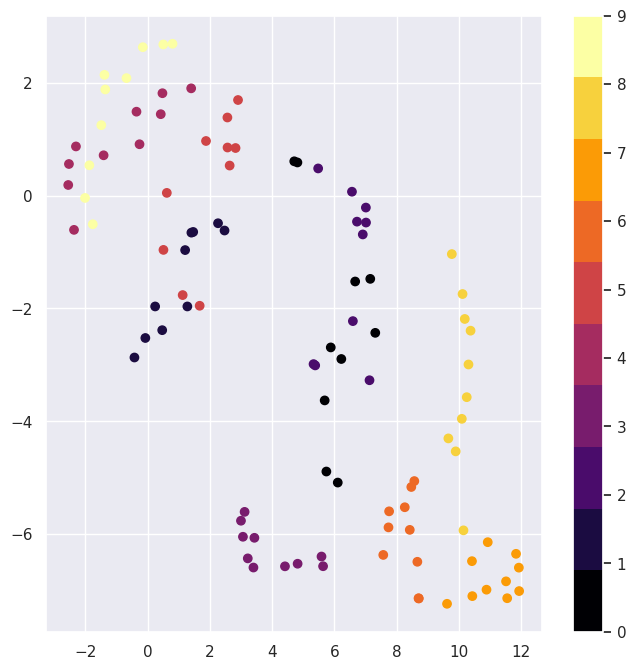

In [ ]:
plot(x_test, y_test)